# Влияние погодных условий на количество аренд велосипедов в Лондоне
Автор: [Владимир Сизов](mailto:vladimirsizov@yandex.ru)

### Введение
В этом блокноте представлен анализ количества аренды велосипедов в Лондоне c 2015-01-04 по 2017-01-03. 

Мы будем исследовать:
- какие факторы погодных условий и на сколько влияют на изменения количества аренды велосипедистов.
- как **сезонность**, **праздничные дни** и **погодные условия** (влажность, температура, скорость ветра) влияют на точность предсказаний количества аренд велосипедов.

Мы используем метод линейной регрессии для определения размера влияния, а также библиотеку fbprophet для предсказания количества аренды велосипедов.
Fbprophet реализует обобщенную аддитивную модель и, моделирует временной ряд как сумму различных компонентов (нелинейный тренд, периодические компоненты и праздники или особые события) и позволяет включать регрессоры.

<hr>

Сначала мы исследуем некоторые характеристики почасовых и недельных циклов, построим модель линейной регрессии, а также построим модель сначала без, а затем с погодными регрессорами.

In [1]:
# ипортируем библиотеки

# работы с массивами данных и математическими преобразованиями
import pandas as pd
import numpy as np
from patsy import dmatrices

# тесты
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

# предсказание и календарь праздничных событий
from fbprophet import Prophet
from fbprophet.make_holidays import make_holidays_df

# отображение значений дней недели для графика
from calendar import day_abbr

# отображение графиков
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize': (16,6)})

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# мы будем работать с уже подготовленными данными
df = pd.read_csv('data_london.csv', parse_dates=['timestamp'])
df['month'] = df.timestamp.dt.month
df.head()

,timestamp,count,temperature,humidity,wind,month
0,2015-01-04 00:00:00,182,3.0,93.0,6.0,1
1,2015-01-04 01:00:00,138,3.0,93.0,5.0,1
2,2015-01-04 02:00:00,134,2.5,96.5,0.0,1
3,2015-01-04 03:00:00,72,2.0,100.0,0.0,1
4,2015-01-04 04:00:00,47,2.0,93.0,6.5,1


Описание данных:  
timestamp – дата и время    
count – количество аренд велосипедов  
temperature – температура, С   
humidity – влажность (%)  
wind – скорость ветра, км/ч

<hr>

# 1. Разведочный анализ данных
Мы хотим посмотреть на наши данные повнимательнее, какие тенденции существуют и что можно сравнить.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    17414 non-null  datetime64[ns]
 1   count        17414 non-null  int64         
 2   temperature  17414 non-null  float64       
 3   humidity     17414 non-null  float64       
 4   wind         17414 non-null  float64       
 5   month        17414 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 816.4 KB


Посмотрим на количество велосипедистов в зависимости от дня недели и времени суток

In [4]:
# добавим некоторые колонки к данным
hour_week = df[['timestamp', 'count']].copy()
hour_week['day_of_week'] = hour_week['timestamp'].dt.dayofweek
hour_week['hour'] = hour_week['timestamp'].dt.hour

hour_week = hour_week.groupby(['day_of_week', 'hour']).mean().unstack()
hour_week.columns = hour_week.columns.droplevel(0)

In [5]:
# график нагрузки в зависимости от дня недели и времени суток
def heatmap_hour_week(data):
    f, ax = plt.subplots()
    sns.heatmap(data, ax=ax, cmap='Reds', \
                vmin=data.min().min(), vmax=data.max().max(), \
                cbar_kws={'boundaries':np.arange(data.min().min(), data.max().max())})
    f.axes[1].set_ylabel('cyclists number')
    ax.set_title('Number of cyclists per day of week and hour of the day')
    ax.set_xlabel('hour of the day')
    ax.set_ylabel('day of the week')
    ax.set_yticklabels(day_abbr[0:7]);

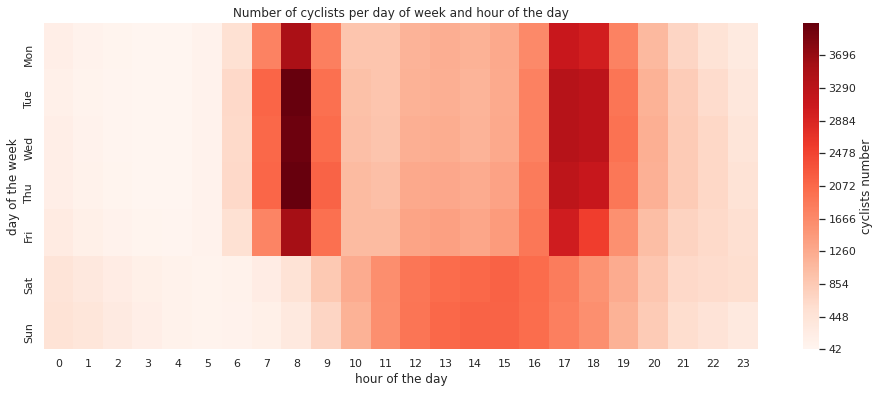

In [6]:
# тепловая карта количества арендованых велосипедов в зависимости от дня недели и времени суток
heatmap_hour_week(hour_week)

Лобопытно посмотреть на корреляцию между количеством аренд велосипедов и показателями погодных условий

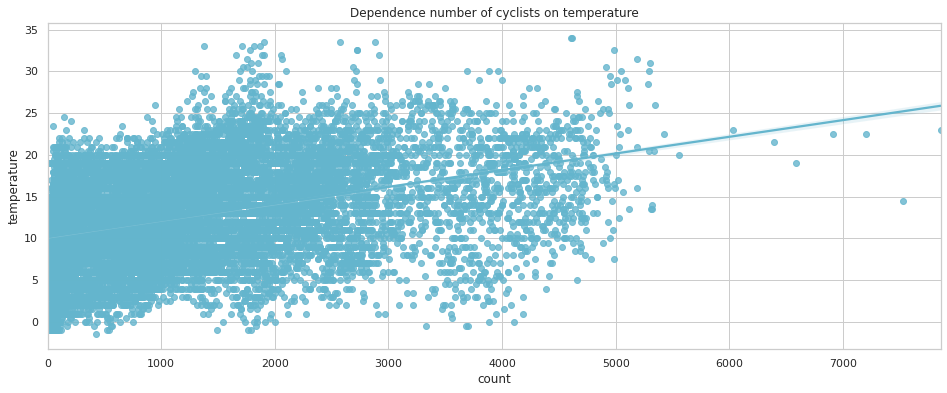

In [7]:
# отношение температуры на количество аренд велосипедов
sns.regplot(data=df, x='count', y='temperature', color='c').set(title='Dependence number of cyclists on temperature');

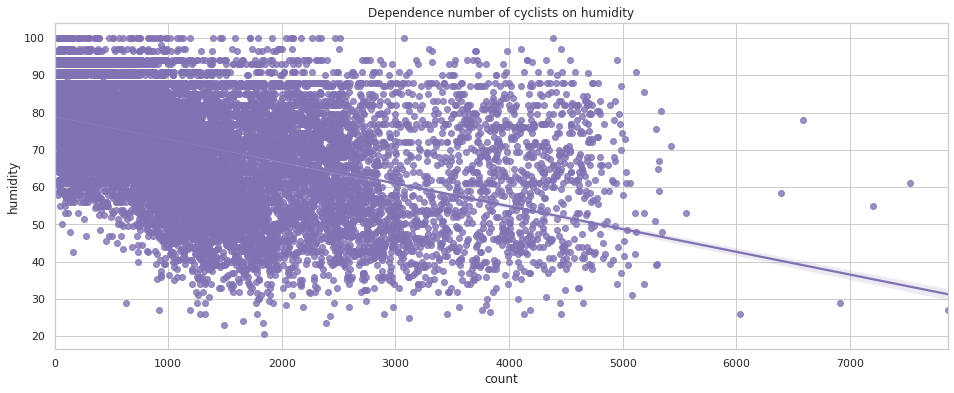

In [8]:
# отношение влажности на количество аренд велосипедов
sns.regplot(data=df, x='count', y='humidity', color='m').set(title='Dependence number of cyclists on humidity');

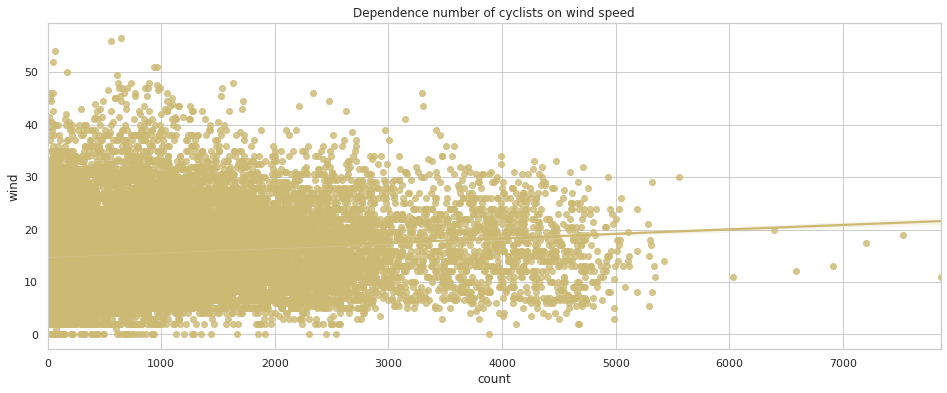

In [9]:
# отношение скорости ветра на количество аренд велосипедов
sns.regplot(data=df, x='count', y='wind', color='y').set(title='Dependence number of cyclists on wind speed');

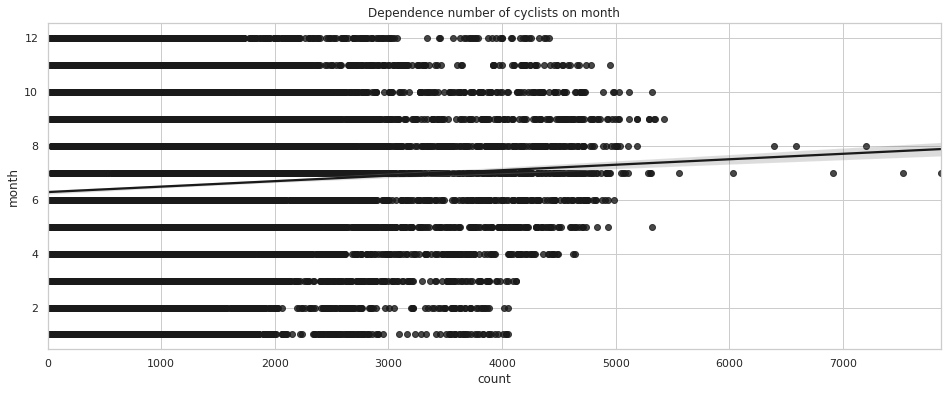

In [10]:
# отношение числа месяца на количество аренд велосипедов
sns.regplot(data=df, x='count', y='month', color='k').set(title='Dependence number of cyclists on month');

<hr>

# 2. Регрессионный анализ
Оценим влияние погодных условий на количество аренд велосипедов

In [11]:
reg = df.copy()
reg.head()

,timestamp,count,temperature,humidity,wind,month
0,2015-01-04 00:00:00,182,3.0,93.0,6.0,1
1,2015-01-04 01:00:00,138,3.0,93.0,5.0,1
2,2015-01-04 02:00:00,134,2.5,96.5,0.0,1
3,2015-01-04 03:00:00,72,2.0,100.0,0.0,1
4,2015-01-04 04:00:00,47,2.0,93.0,6.5,1


In [12]:
# определяем переменные
y = reg['count']
# предикторы
x = reg[['temperature', 'humidity', 'wind', 'month']]

In [13]:
#добавляем константу
x = sm.add_constant(x)

In [14]:
# подбираем модель линейной регрессии 
model = sm.OLS(y, x).fit()

In [15]:
#смотрим сводку
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     1505.
Date:                Fri, 14 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:08:23   Log-Likelihood:            -1.4384e+05
No. Observations:               17414   AIC:                         2.877e+05
Df Residuals:                   17409   BIC:                         2.877e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2678.3135     57.056     46.941      

R-squared показывает что предикторы объясняют 25.7% дисперсии.  

pvalue<0.05 всех параметров, сообщает что все предикторы имеют статистически значимую связь с  количеством аренд велосипедов.

коэффициенты:  
temperature    41.0623  
humidity      -28.6745  
wind           -2.7812  
month          10.8919  
для каждой переменной-предиктора говорят нам о среднем ожидаемом изменении переменной отклика, предполагая, что другая переменная-предиктор остается постоянной.

расчётная формула:  
y = 2678 + 41.0623 * temperature - 28.6745 * humidity - 2.7812 * wind + 10.8919 * month

<hr>
Теперь посмотрим как это влияет на прогнозирование заказов

## Проверка модели

### Графики остатков
Проверяем, существует ли линейная зависимость между независимой переменной и зависимыми переменными, а также на гетероскедастичность остатков.  
В частности, проверим на отсутствие корреляции между последовательными остатками в данных временных рядов.

eval_env: 1


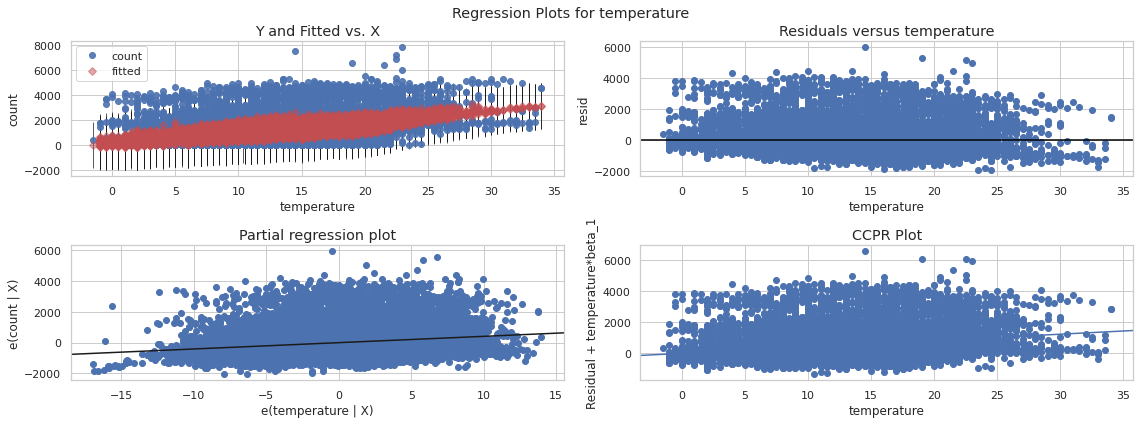

In [16]:
# температура temperature
fig = plt.figure()
fig = sm.graphics.plot_regress_exog(model, 'temperature', fig=fig)

eval_env: 1


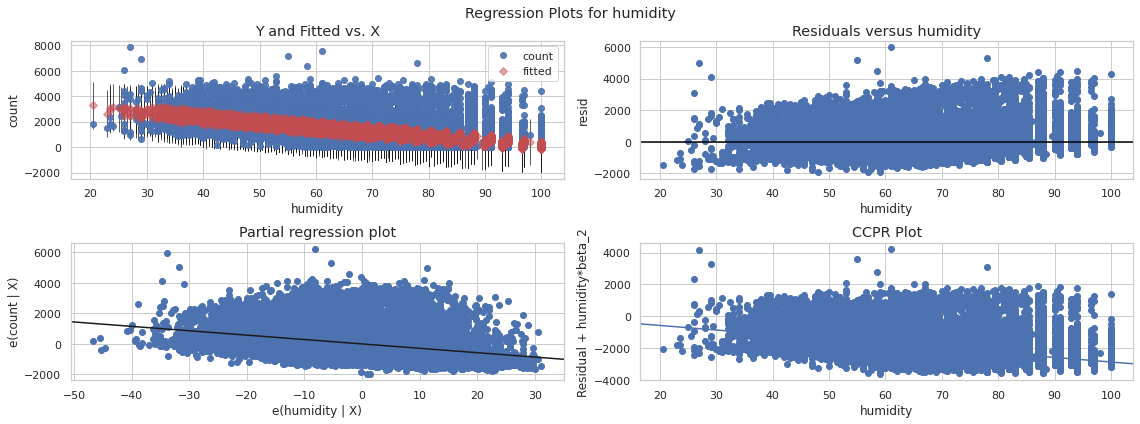

In [17]:
# влажность humidity
fig = plt.figure()
fig = sm.graphics.plot_regress_exog(model, 'humidity', fig=fig)

eval_env: 1


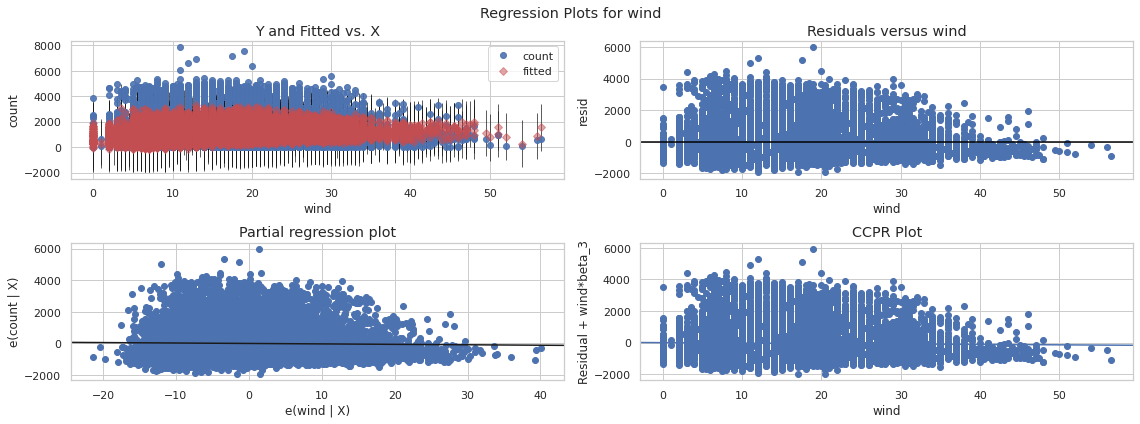

In [18]:
# сила ветра wind
fig = plt.figure()
fig = sm.graphics.plot_regress_exog(model, 'wind', fig=fig)

eval_env: 1


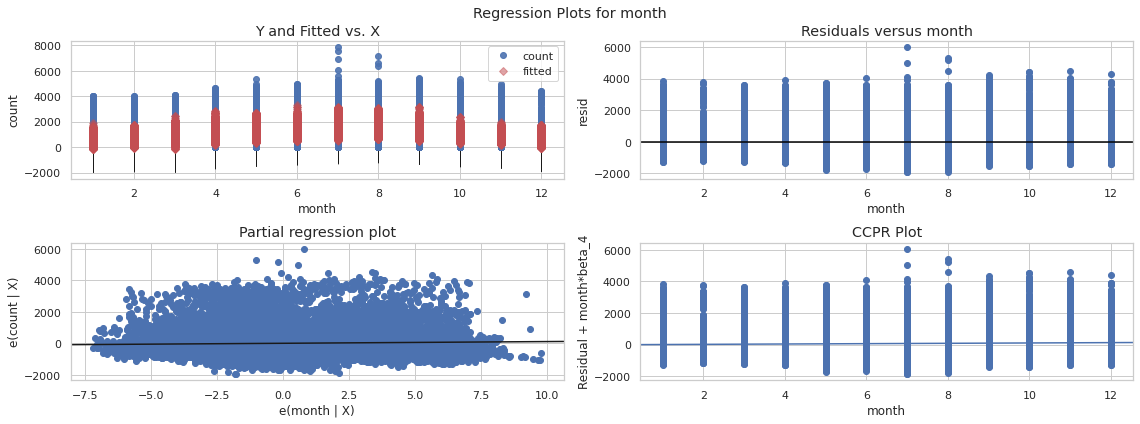

In [19]:
# месяц month
fig = plt.figure()
fig = sm.graphics.plot_regress_exog(model, 'month', fig=fig)

### тест Дарбина-Ватсона
тест на независимость остатков

In [20]:
durbin_watson(model.resid)

0.5836834605644318

Сообщает что остатки не находятся в диапазоне 1.5-2.5, это значит остатки автокоррелированы, и это несколько ухудшает прогноз.

### тест Бреуша-Пагана
тест на гомоскедастичность остатков, наличие постоянной дисперсии

In [21]:
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)
lzip(names, test)

[('Lagrange multiplier statistic', 140.57821230417875),
 ('p-value', 2.122522142864705e-29),
 ('f-value', 35.420400892235584),
 ('f p-value', 1.6279760603404602e-29)]

Так как pvalue>0.05, присутствует гомоскедастичность

### тесты на Нормальность распределений
Проверим на нормальность распределений, что остатки модели нормально распределены.
### графики QQ-plot

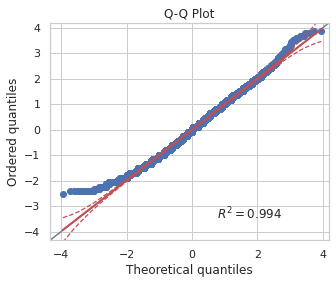

In [22]:
# температура temperature
pg.qqplot(df.temperature);

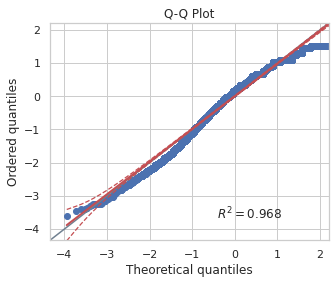

In [23]:
# влажность humidity
pg.qqplot(df.humidity);

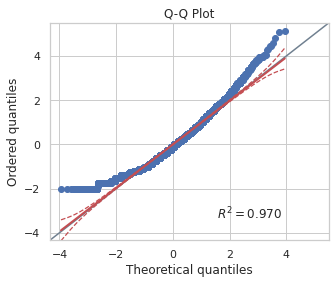

In [24]:
# сила ветра wind
pg.qqplot(df.wind);

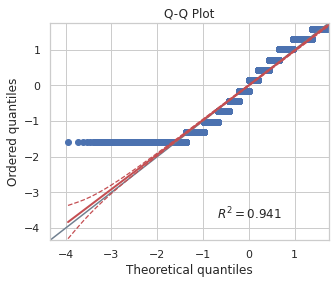

In [25]:
# месяц month
pg.qqplot(df.month);

### тест Харке-Бера
Проверяем на ассиметрию и эксцесс у нормального распределения

In [26]:
# температура temperature
stats.jarque_bera(df.temperature)

Jarque_beraResult(statistic=170.38719698941566, pvalue=0.0)

In [27]:
# влажность humidity
stats.jarque_bera(df.humidity)

Jarque_beraResult(statistic=999.5962464564715, pvalue=0.0)

In [28]:
# сила ветра wind
stats.jarque_bera(df.wind)

Jarque_beraResult(statistic=1444.914730501016, pvalue=0.0)

In [29]:
# месяц month
stats.jarque_bera(df.month)

Jarque_beraResult(statistic=1060.9766778189871, pvalue=0.0)

pvalue<0.05, значения имеют ассиметрию и эксцесс значительно отличающуюся от нормального распределения

### тест VIF
Проверяем на мультиколлинеарность (коэффециент инфляции дисперсии)

In [30]:
# определяем матрицу для модели линейной регрессии используя'count' в качестве зависимой переменной
y, X = dmatrices('count ~ temperature+humidity+wind+month', data=df, return_type='dataframe')

In [31]:
# рассчитать VIF для каждой независимой переменной
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

In [32]:
# VIF для каждой независимой переменной
vif

,VIF,variable
0,64.777609,Intercept
1,1.540669,temperature
2,1.454939,humidity
3,1.096394,wind
4,1.251261,month


1 - отсутствие корреляции  
1-5 - указывает на умеренную корреляцию между данной и другими независимыми переменными  
больше 5 потенциально сильная корреляця между данной независимой переменной и другими независимыми переменными в модели.   
<hr>

# 3. Предсказание количества поездок с помощью fbprophet

Оценим влияние погодных условий на предсказание количества аренд велосипедов

Мы разделяем временные ряды на:
- обучающую выборку data_train (484 дня), с 2015-01-04 по 2016-04-30
- тестовую выборку data_test (248 дней), с 2016-05-01 по 2017-01-03

Модель будет установлена на обучающем наборе и оценена на тестовом наборе (вне выборочного прогноза), чтобы обеспечить достоверную оценку производительности модели.
Серая вертикальная полоса на рисунке ниже отмечает разделение между обучающим и тестовым наборами.
В оценке влияния регрессоров мы не будем использовать данные датафрейма колонки month, так как в сезонное влияние есть в настройках fbprophet

### Подготовка данных для предсказания количества аренды велосипедов

In [33]:
# группировка данных из формата "по часам" в формат "по дням"
def group_by_day(df):
    df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d')
    df = df.groupby('timestamp').agg({'count': 'sum', \
                                      'temperature': 'mean', \
                                      'humidity': 'mean', \
                                      'wind': 'mean'}).reset_index()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

In [34]:
# сгруппируем данные по дням
df = group_by_day(df)

In [35]:
# нам необходимо переименовать некоторые столбцы потому что 
# fbprophet принимает данные timeseries через переменную ds, значения для предсказания в y
df.rename(columns={'timestamp': 'ds', 'count': 'y'}, inplace=True)
df.head()

,ds,y,temperature,humidity,wind
0,2015-01-04,9234,2.479167,94.270833,7.500000
1,2015-01-05,20372,8.041667,80.312500,8.854167
2,2015-01-06,20613,7.854167,78.895833,16.000000
3,2015-01-07,21064,7.456522,78.108696,19.760870
4,2015-01-08,15601,9.750000,79.312500,20.479167


In [36]:
# делим данные на для обучения и для проверки качества предсказания
cut_date = '2016-05-01'
cut_date = pd.to_datetime(cut_date).strftime('%Y-%m-%d %H:%M:%S')

In [37]:
# диапазон дат для data_train
data_train = df[df.ds < cut_date]
data_train.ds.min(), data_train.ds.max()

(Timestamp('2015-01-04 00:00:00'), Timestamp('2016-04-30 00:00:00'))

In [38]:
# диапазон дат для data_test
data_test = df[df.ds >= cut_date].reset_index(drop=True)
data_test.ds.min(), data_test.ds.max()

(Timestamp('2016-05-01 00:00:00'), Timestamp('2017-01-03 00:00:00'))

In [39]:
# собираем праздничные дни, чтобы отслеживать сезонную активность при построении модели
year_list = [i for i in range(df.ds.dt.year.min(), df.ds.dt.year.max()+1)]
df_holidays = make_holidays_df(year_list=year_list, country='UK')
year_list

[2015, 2016, 2017]

## Прогноз без регрессоров
Первым шагом в fbprophet является создание экземпляра модели.  
Здесь устанавливаем prior scales для каждого компонента вашего временного ряда.

Также количество рядов Фурье, которые будут использоваться для моделирования циклических компонентов.
Общее правило состоит в том, что большие априорные масштабы и большее количество рядов Фурье сделают модель более гибкой, но за счет потенциального обобщения модель может переобучиться, изучая шум (а не сигнал) в обучающих данных, что дает плохие результаты при применении к тестовым данным.

Установка этих гиперпараметров может быть больше искусством, чем наукой.

In [40]:
# настраиваем модель
m = Prophet(mcmc_samples=300, \
            holidays=df_holidays, \
            holidays_prior_scale=0.25, \
            changepoint_prior_scale=0.01, \
            seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [41]:
# тренируем модель на данных
m.fit(data_train)

In [42]:
# создаём датафрейм для регрессоров
futures = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [43]:
# предсказываем
forecast = m.predict(futures)

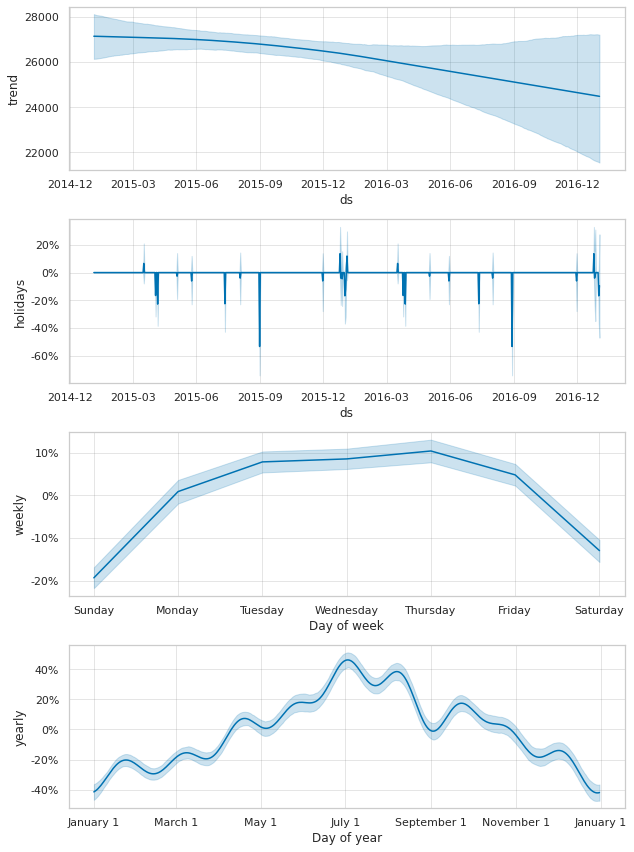

In [44]:
# графики с показателями точности предсказаний трендов, праздников, недельной и годовой сезональности
f = m.plot_components(forecast)

In [45]:
# сборка датафрейма данных результатов прогноза и фактических результатов
def make_verif(forecast, data_train, data_test): 
    forecast.index = pd.to_datetime(forecast.ds)
    data_train.index = pd.to_datetime(data_train.ds)
    data_test.index = pd.to_datetime(data_test.ds)
    data = pd.concat([data_train, data_test], axis=0)
    forecast.loc[:,'y'] = data.loc[:,'y']
    return forecast

In [46]:
# собираем датафрейм с данными результатов прогноза и фактических результатов
verif = make_verif(forecast, data_train, data_test)
verif.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2015-01-04,2015-01-04,27142.351637,4985.751841,17195.850156,26136.772998,28121.976957,0.0,0.0,0.0,0.0,...,-0.217824,-0.169001,-0.397242,-0.444902,-0.349118,0.0,0.0,0.0,11103.783586,9234.0
2015-01-05,2015-01-05,27141.568917,10128.593746,22813.573440,26141.382575,28111.993406,0.0,0.0,0.0,0.0,...,-0.019372,0.035819,-0.387981,-0.433837,-0.341161,0.0,0.0,0.0,16845.786052,20372.0
2015-01-06,2015-01-06,27140.786197,13178.956031,25430.818334,26145.992152,28098.141661,0.0,0.0,0.0,0.0,...,0.053442,0.102644,-0.377554,-0.422690,-0.332340,0.0,0.0,0.0,19015.378689,20613.0
2015-01-07,2015-01-07,27140.003477,13556.425282,26423.330484,26146.082914,28090.133128,0.0,0.0,0.0,0.0,...,0.061576,0.109259,-0.366141,-0.408912,-0.323448,0.0,0.0,0.0,19514.693770,21064.0
2015-01-08,2015-01-08,27139.220757,13876.913895,26817.510934,26150.157522,28079.922308,0.0,0.0,0.0,0.0,...,0.077222,0.130333,-0.353934,-0.394049,-0.313351,0.0,0.0,0.0,20350.485796,15601.0


In [47]:
# построение графика результата прогноза
def plot_verif(verif, forecast_date):
    f, ax = plt.subplots()
    train = verif.loc[:str(forecast_date),:] #-1
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    test = verif.loc[str(forecast_date):,:]
    ax.plot(test.index, test.y, 'ro', markersize=3)
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    ax.axvline(pd.to_datetime(forecast_date), color='0.8', alpha=0.7)
    ax.grid(ls=':', lw=0.5)
    return f

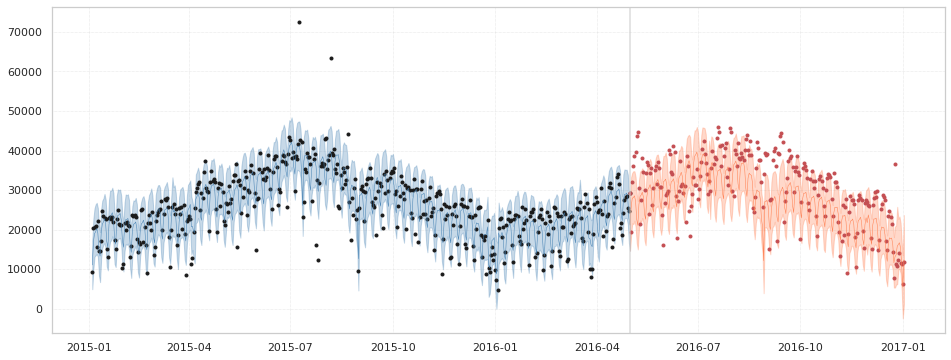

In [48]:
# построим графика результата прогноза
f = plot_verif(verif, cut_date)

In [49]:
# подсчет ошибок предсказания
def absolute_error(forecast):
    cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
    cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
    cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
    mape = np.mean(abs(cmp_df[-len(data_test):]['p']))
    mae = np.mean(abs(cmp_df[-len(data_test):]['e']))
    print('MAPE (средняя абсолютная ошибка в процентах) – ', mape,'%')
    print('MAE (средняя абсолютная ошибка) – ', mae)
    return [mape, mae]

In [50]:
# Смотрим на ошибки модели
ae_without_reg = absolute_error(forecast)

MAPE (средняя абсолютная ошибка в процентах) –  19.800832454432708 %
MAE (средняя абсолютная ошибка) –  5912.05733521978


## Прогноз с регрессорами
Для корректности сравнения, мы используем те же срезы данных что и для прогноза без регрессоров

In [51]:
# настраиваем модель
m = Prophet(mcmc_samples=300, \
            holidays=df_holidays, \
            holidays_prior_scale=0.25, \
            changepoint_prior_scale=0.01, \
            seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [52]:
# настраиваем регрессоры
m.add_regressor('temperature', prior_scale=0.5, mode='multiplicative')
m.add_regressor('humidity', prior_scale=0.5, mode='multiplicative')
m.add_regressor('wind', prior_scale=0.5, mode='multiplicative')

In [53]:
# тренируем модель на данных
m.fit(data_train)

In [54]:
# создаём датафрейм для регрессоров
futures = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [55]:
# собираем данные регрессоров
data_with_regressors = df.set_index('ds')
regressors = [data_with_regressors.temperature, data_with_regressors.humidity, data_with_regressors.wind]

In [56]:
# создание датафрейм с данными регрессоров
def add_regressor_to_future(futures, regressors): 
    futures = futures.copy()
    futures.index = pd.to_datetime(futures.ds)
    df_regressors = pd.concat(regressors, axis=1)
    futures = futures.merge(df_regressors, left_index=True, right_index=True)
    futures = futures.reset_index(drop=True)
    return futures

In [57]:
# собираем датафрейм с регрессорами
futures = add_regressor_to_future(futures, regressors)
futures.head()

,ds,temperature,humidity,wind
0,2015-01-04,2.479167,94.270833,7.500000
1,2015-01-05,8.041667,80.312500,8.854167
2,2015-01-06,7.854167,78.895833,16.000000
3,2015-01-07,7.456522,78.108696,19.760870
4,2015-01-08,9.750000,79.312500,20.479167


In [58]:
# предсказываем
forecast = m.predict(futures)

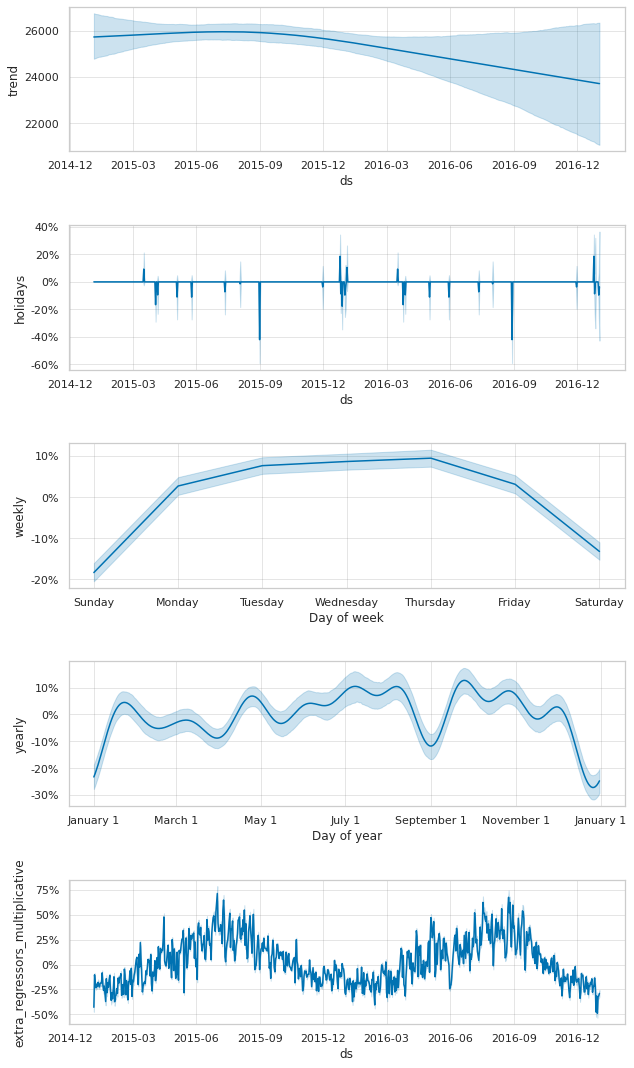

In [59]:
# графики с показателями точности предсказаний трендов, праздников, недельной и годовой сезональности
f = m.plot_components(forecast)

In [60]:
# собираем датафрейм с данными результатов прогноза и фактических результатов
verif = make_verif(forecast, data_train, data_test)
verif.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,...,wind_lower,wind_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2015-01-04,2015-01-04,25734.004108,141.941173,9580.177597,24790.962193,26760.120772,0.0,0.0,0.0,0.0,...,0.108230,0.138800,-0.196378,-0.240491,-0.150800,0.0,0.0,0.0,4920.175965,9234
2015-01-05,2015-01-05,25735.339668,14391.187763,24078.511730,24802.980156,26752.630463,0.0,0.0,0.0,0.0,...,0.092460,0.118576,-0.179547,-0.223656,-0.133380,0.0,0.0,0.0,19141.801695,20372
2015-01-06,2015-01-06,25736.675228,13871.219182,23457.457758,24815.234475,26737.335316,0.0,0.0,0.0,0.0,...,0.009245,0.011856,-0.161886,-0.206181,-0.116961,0.0,0.0,0.0,18807.008602,20613
2015-01-07,2015-01-07,25738.010789,13504.536833,23369.845640,24827.488794,26730.832348,0.0,0.0,0.0,0.0,...,-0.044310,-0.034551,-0.143673,-0.187117,-0.100238,0.0,0.0,0.0,18256.984906,21064
2015-01-08,2015-01-08,25739.346349,15054.143925,24811.637927,24840.645451,26727.168216,0.0,0.0,0.0,0.0,...,-0.055038,-0.042916,-0.125188,-0.169001,-0.083263,0.0,0.0,0.0,19862.878704,15601


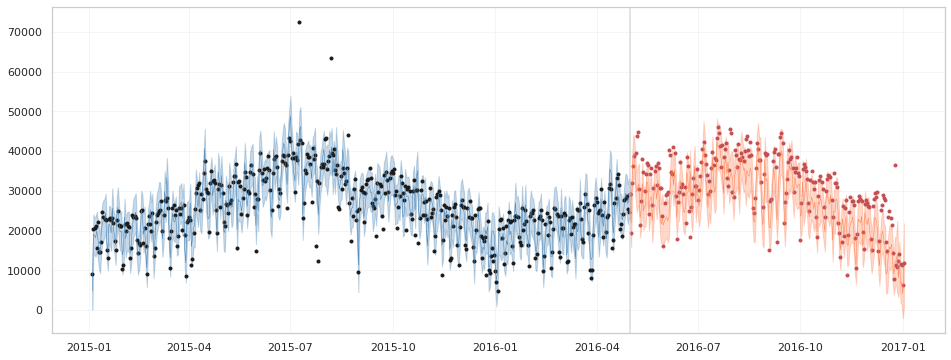

In [61]:
# построим графика результата прогноза
f = plot_verif(verif, cut_date)

In [62]:
# Смотрим на ошибки модели
ae_with_reg = absolute_error(forecast)

MAPE (средняя абсолютная ошибка в процентах) –  16.112136567593534 %
MAE (средняя абсолютная ошибка) –  4657.778115137795


In [63]:
# точность прогноза с регрессоров при сравнении с прогнозом без
print('Точность прогноза с использованием регрессоров при сравнении без, в', \
      round(ae_without_reg[0] / ae_with_reg[0], 2), 'раза.')

Точность прогноза с использованием регрессоров при сравнении без, в 1.23 раза.
